# **Modeling - Data Split**

In [ ]:
#Models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IBE/4th Semester/Master Thesis/Codes/Data/frenchclaim_prep.csv")   #data prepared

In [ ]:
# Define response name and features names
#Exposure and ClaimNb are not included in the model as it is part of the calculation of Freq

#Freq is the response variable, group_id used only in terms of split
y, x = df.columns[1], list(df.loc[:, ~df.columns.isin(['Freq', 'group_id', 'Unnamed: 0'])])

print("The response name:", y)
print("The feature names:", x)

The response name: Freq
The feature names: ['VehPower', 'VehAge', 'VehBrand', 'VehGas', 'DrivAge', 'logDensity', 'PolicyRegion']


In [ ]:
# split the data into 80% training and 20% test

# Stratified split by group_id to minimize bias
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['group_id'])
train_inds, test_inds = next(split)

train = df.iloc[train_inds]
test = df.iloc[test_inds]

# **The true model**

In [ ]:
#It is define the corresponding function for the true underlying frequency model

#Variables included:
#VehPower
#VehAge
#VehBrand
#VehGas -> binary variable
#DriveAge
#logDensity
#PolicyRegion

def age_effect(age):
    x = (age - 66) / 60
    return 0.05 + x**8 + 0.4 * x**3 + 0.3 * x**2 + 0.06 * x

def true_model(X):
    """Returns pd.Series of true expected frequencies."""
    df = pd.DataFrame(X, columns=x)  # Needed because SHAP turns df to np.array
    log_lambda = ((
        ((0.09 * df.VehPower)* df.PolicyRegion)/1000  #linear effect of vehpower depending of policyregion
        + np.log(age_effect(df.DrivAge))                      #Highly non-linear and additive driver_age effect
        + 0.5* df.logDensity                                       #high positve log density effect
         + (df.VehAge * df.VehBrand)                #interaction effect between VehBrand and VehGas
        - 0.01* df.VehGas)  #negative effect
        )

    return np.exp(log_lambda)

In [ ]:
# Test - evaluation of the function
true_model(df.head())

0    1.670699e+00
1    1.670699e+00
2    9.309438e+09
3    4.439930e-01
4    4.439930e-01
dtype: float64

#**SHAP** **analysis**

Select explanation data

In [ ]:
X_explain = train[x].sample(n=1000, random_state=937)
print("Shape of X_explain:", X_explain.shape)

Shape of X_explain: (1000, 7)


In [ ]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 17.7 MB/s eta 0:00:00


In [ ]:
# Background data (same for the GLM, the neural net, and the true model)
X_bg = train[x].sample(200, random_state=8366)

# Subset
nsamples = 2 ** len(x) - 2

# **True model with Kernel SHAP**

In [ ]:
true_explainer = shap.KernelExplainer(lambda x: np.log(true_model(x)), data=X_bg)
shap_true = true_explainer.shap_values(X_explain, nsamples=nsamples)

  0%|          | 0/1000 [00:00<?, ?it/s]

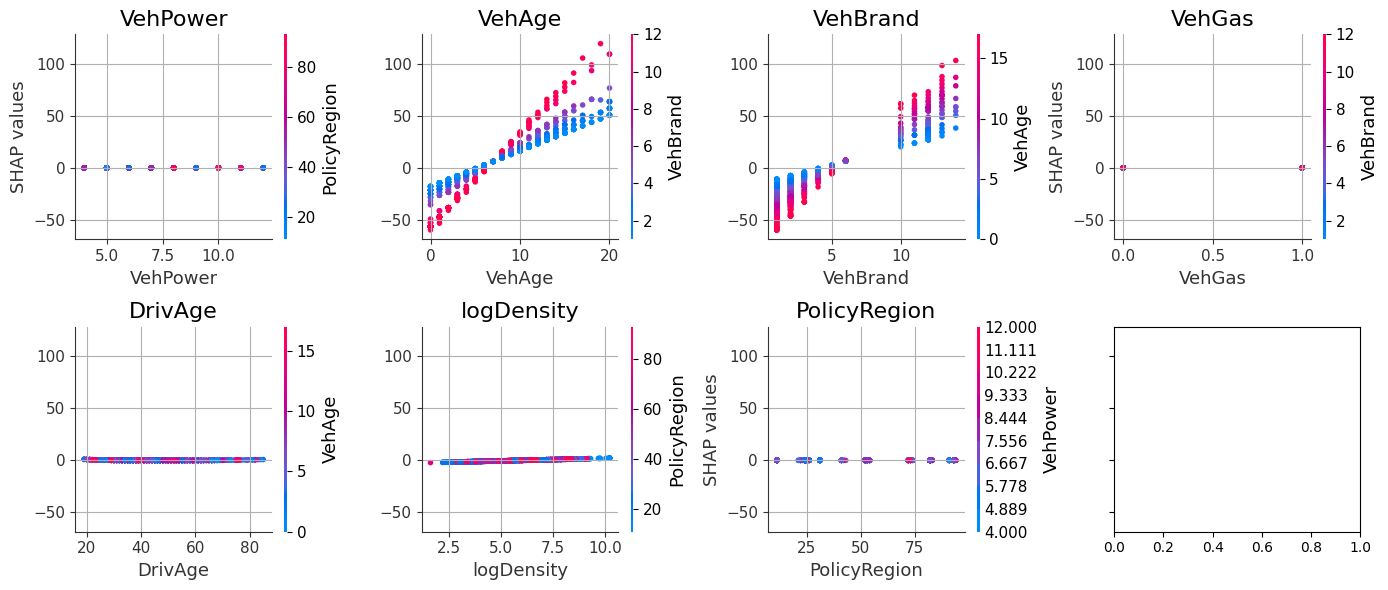

In [ ]:
def all_dep_plots(x, shap_values, X):
    """Dependence plots for all features x."""
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6), sharey=True)

    for i, ax in enumerate(axes.flat):
        if i < len(x):
            xvar = x[i]
            shap.dependence_plot(
                xvar,
                shap_values,
                features=X,
                # x_jitter=0.2,
                # ymin=-ymin,
                # ymax=1,
                ax=ax,
                show=False,
            )
            ax.set_title(xvar, fontdict={"size": 16})
            ax.set_ylabel("SHAP values" if i % 3 == 0 else "")
            ax.grid()

    plt.tight_layout()

# Call the modified function with your data
all_dep_plots(x, shap_true, X_explain)

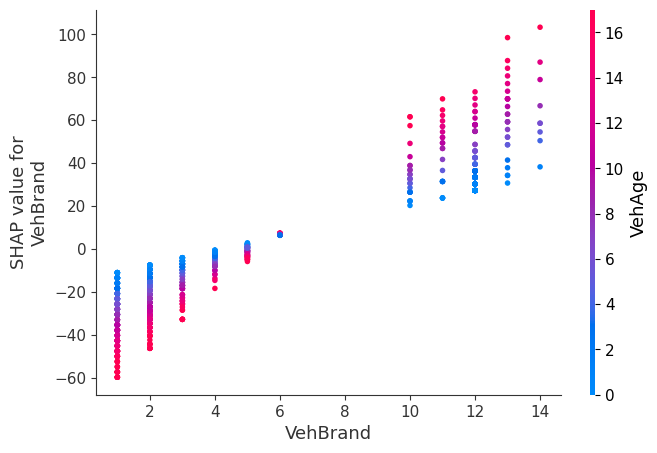

In [ ]:
shap.dependence_plot(2, shap_true, X_explain)

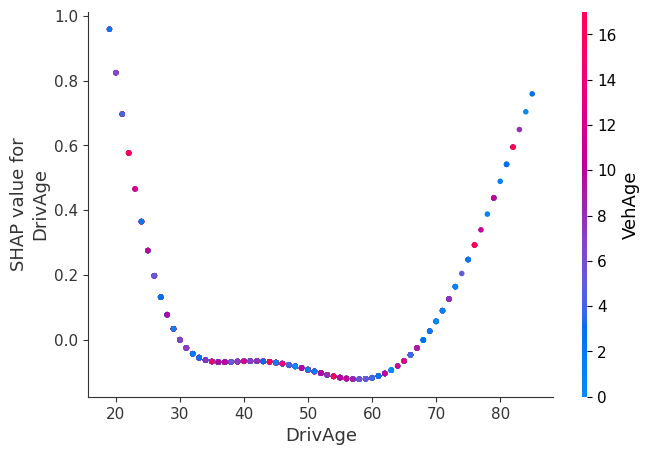

In [ ]:
shap.dependence_plot(4, shap_true, X_explain)

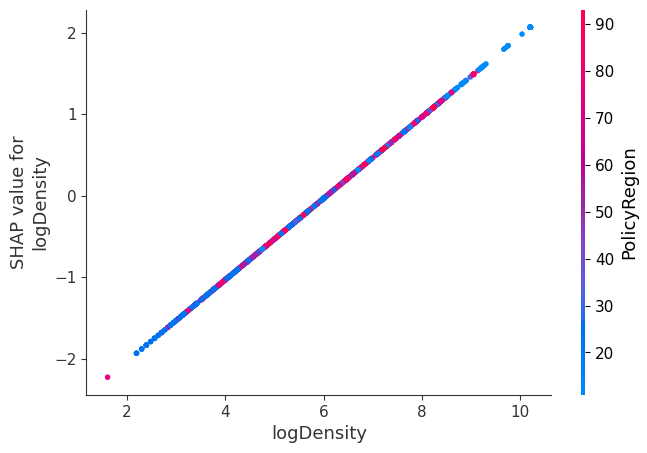

In [ ]:
shap.dependence_plot(5, shap_true, X_explain)

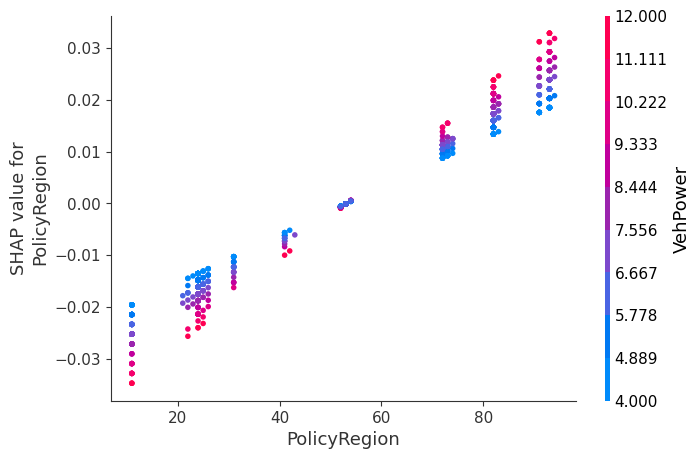

In [ ]:
shap.dependence_plot(6, shap_true, X_explain)

  0%|          | 0/1 [00:00<?, ?it/s]

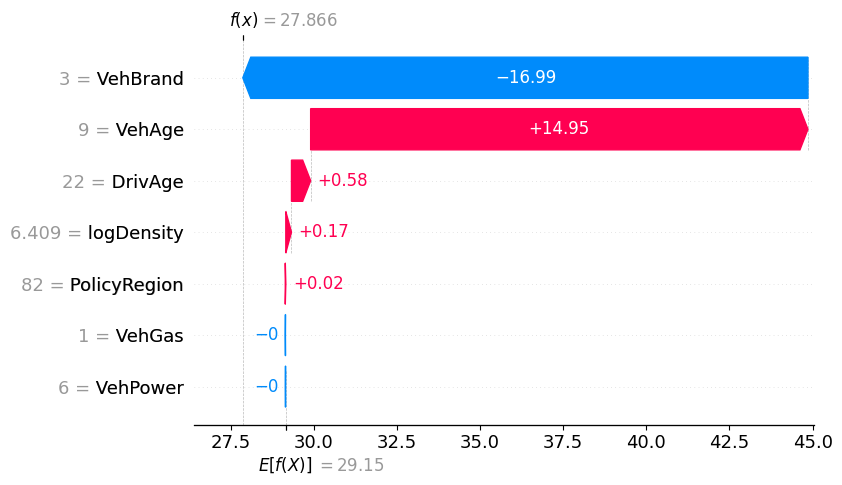

In [ ]:
# waterfall plot
# Compute SHAP values for a single instance
shap_values = true_explainer.shap_values(X_explain.iloc[0:1]) # Use .iloc to access row by position

# Plot the waterfall plot for the first instance
shap.plots.waterfall(shap.Explanation(values=shap_values[0],
                                       base_values=true_explainer.expected_value, # Use glm_explainer instead of explainer
                                       data=X_explain.iloc[0], # Use .iloc to access row by position
                                       feature_names=X_explain.columns)) # Use column names from X_bg

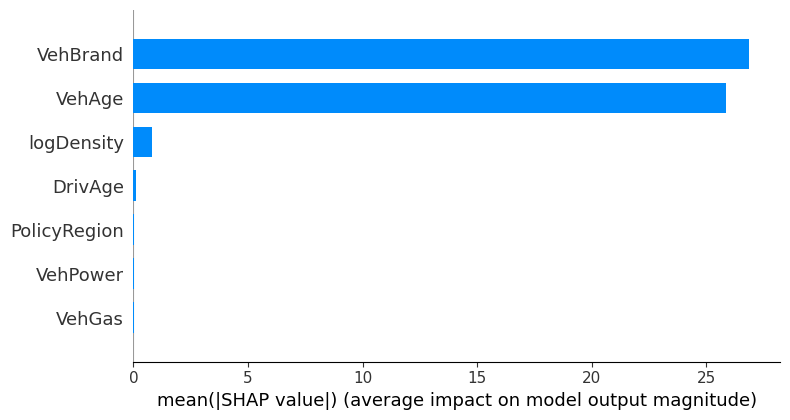

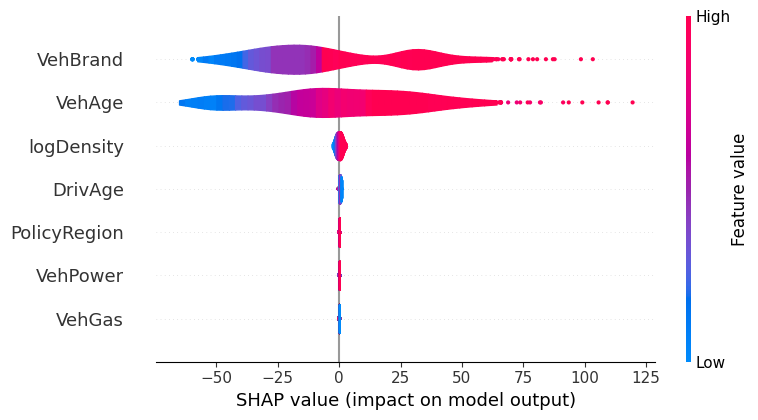

In [ ]:
for t in ("bar", "violin"):
    shap.summary_plot(shap_true, features=X_explain, plot_type=t, title=t)

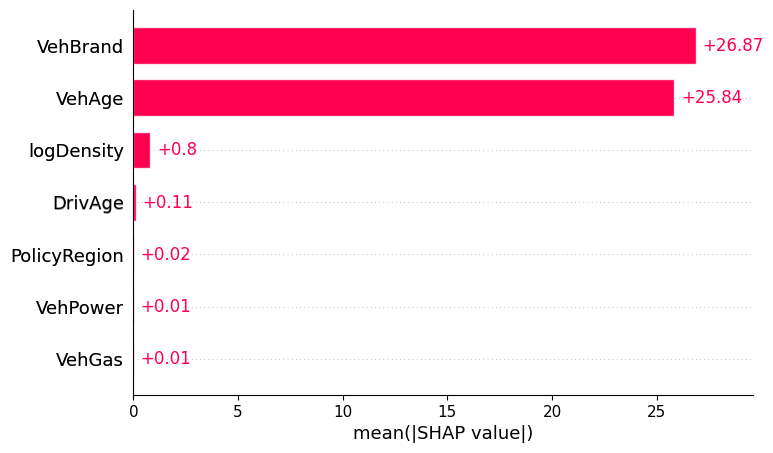

In [ ]:
shap.plots.bar(shap.Explanation(values=shap_true, feature_names=X_explain.columns))